# Modelación de flujo de agua subterránea en un medio homogéneo con FEniCS


* Autor: Ricardo Balam Chagoya Morales


### Modelo conceptual

El modelo conceptual-teórico consiste en una porción de acuífero rectangular de 200 m en
dirección E-O y 100 m en dirección N-S que se extiende sobre un plano de ladera con echado
en dirección este. Las mediciones de la carga hidráulica indican valores de h = 100m en la
frontera izquierda (Oeste) y h = 10m en la frontera derecha (Este), mientras que tanto la
frontera superior (Norte) como la inferior (Sur) colindan con formaciones no permeables.



<img src="../Tesis/Figura_25c.png" alt="Figura_25c.png" width="400"/>

### Modelo matemático

El caso homogéneo es el más simple, ya que la función de conductividades
hidráulicas adquieren un valor constante

$$K(x; y; z) = C$$. 

La ecuación diferencial a resolver, es la ecuación de flujo, que se obtiene de juntar la ecuación de continuidad y la ley de Darcy para el movimiento de fluidos en medios porosos

 $$\dfrac{\partial^{2}h}{\partial{x^{2}}}+\dfrac{\partial^{2}h}{\partial{y^{2}}}=0$$
 
Donde las condiciones de frontera son representadas por condiciones de Dirichlet en las fronteras Este-Oeste y condiciones de Neumann en las fronteras Norte-Sur.


 $$\nabla^{2}h(x,y)=0 \quad en \quad \Omega$$

 $$h(x,y)=100 \quad en \quad {\partial}{\Omega}_{D1}$$


 $$h(x,y)=10 \quad en \quad {\partial}{\Omega}_{D2}$$
 
 $${\nabla}h{\cdot}\textbf{n}=0 \quad en \quad {\partial}{\Omega}_{N} $$
  
 Donde ${\nabla}^{2}h$ representa la ecuación de flujo; $\textbf{n}$ es el vector normal a la frontera ${\partial}\Omega$ y la frontera del problema se define como ${\partial}\Omega={\partial}\Omega_{D}{\cup}{\partial}\Omega_{N}$ y ${\partial}{\Omega}_{D}={\partial}\Omega_{D1}{\cup}{\partial}\Omega_{D2}$  . Según las caracteristicas del modelo conceptual, el domino y sus fronteras se plantean de la siguiente forma:
 

$$ \Omega=[0,100]{\times}[0,200] \: \:  Dominio \: rectangular$$

$$ {\partial}\Omega_{D}={(0,y){\cup}(200,y)} \:\:  Condiciones \: de \: Dirichlet$$

$$ {\partial}\Omega_{N}={(x,0){\cup}(x,100)} \: \: Condiciones \: de \: Neumann$$

### Modelo computacional

La solución del problema planteado anteriormente, consiste en obtener el campo de cargas hidráulicas en todo el dominio de estudio, esto se realizará a través del método de elemento finito implementado por la libreria FEniCS escrito en lenguaje python. Además, se hará el cálculo de la descarga especifica en cada punto, suponiendo un valor de conductividad hidráulica para todo el dominio.  

Primero, se realiza la importación de las librerias necesarias para el funcionamiento de FEniCS y el procesamiento realizado posteriormente. Las librerias que se ocupan son *fenics* que contiene todos los componentes necesarios del proyecto, también se puede importar *dolfin*, ambas contienen las mismas funciones y clases; posteriormente se usan la libreria para manejo de datos en forma matricial *numpy* y la libreria matplotlib para graficar los resultados obtenidos de las simulaciones.  

In [17]:
### Se hace la importación de las librerias de python, además de las librerias básicas para cálculo númerico

from __future__ import print_function
from fenics import *
import numpy as np
#import random as ra
import matplotlib.pyplot as plt
#import sys

Se crea la malla donde se define el dominio donde se resolvera la ecuación de flujo, se puede generar a partir de funciones definidas dentro de la libreria *fenics* o crear de forma externa a partir de una herramienta de mallado e importar el archivo en formato XML, haciendo uso de la libreria *meshio* para la conversión de formato. Para este caso, se usará una función predefinida en FEniCS *RectangleMesh*, que genera una malla rectangular con elementos finitos triangulares. Adicionalmente, se genera también el espacio de funciones que tiene como argumentos la malla generada anteriormente, el tipo de polinomio de interpolación, y el grado del polinomio. 

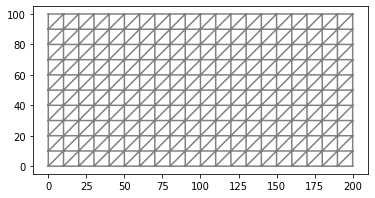

In [18]:
# Se definen los parámetros de la simulación
k = 10 #Conductividad hidráulica
lonx = 200 # Longitud en dirección x
lony = 100 # Longirud en dirección y
delta = 10 # Refinación de malla
elemx = int(lonx/delta) # Número de elementos en x
elemy = int(lony/delta) # Número de elementos en y


# Se crea la malla donde se define el dominio

mesh= RectangleMesh(Point(0,0),Point(lonx,lony),elemx,elemy)
V = FunctionSpace(mesh, 'P', 1)
plot(mesh)



Las condiciones de Dirichlet se generan como una instancia de la clase *DirichletBC*, cuyo constructor tiene 3 argumentos; el espacio de funciones *V*, generada anteriormente junto a la malla; el valor de la carga hidráulica en la frontera y finalmente, la delimitación de la frontera dentro del dominio, esta última se genera a través de una función  donde se realizá un marcado para hacer la delimitación. En este caso, las funciones que delimitan la frontera son *frontera_I* para la frontera izquierda y *frontera_D* para el caso de la frontera derecha, donde se genera un arreglo para cada frontera de Dirichlet definida (en la variable *bc*).

In [19]:
# Se definen las condiciones de fronteras

def frontera_I(x,frontera):
 tol=1E-14    
 if frontera:
  if x[0]<=tol: 
   return True
  else:
   return False 
 else:
  return False  

def frontera_D(x,frontera):
 tol=1E-14    
 if frontera:
  if abs(x[0]-200)<=tol: 
   return True
  else:
   return False 
 else:
  return False  


F_D = DirichletBC(V, Constant(10), frontera_D)
F_I = DirichletBC(V, Constant(100), frontera_I)
bc = [F_D,F_I]


Teniendo definida la malla, el espacio de funciones y las condiciones de frontera; se generan la función de prueba *v* y la variable donde se depositará nuestra solución (*u*). Posteriormente, se definen la parte izquierda y derecha de la formulación débil de la ecuación de flujo. En la parte izquierda, se encuentra la fuente (*f*) que en nuestro caso será nulo $f=0$ y se define en *L* la totalidad del lado izquierdo, mientras que en el lado derecho se encuentra la formulación restante (variable *a*). 

In [20]:
#Se define el problema variacional

u=TrialFunction(V)
v=TestFunction(V)
f=Constant(0)
a=k*dot(grad(u),grad(v))*dx
g=Constant(0)
L=f*v*dx-g*v*ds

Finalmente, con los elementos anteriormente definidos, se genera la solución de forma semiautomática a partir de la función *solve*, que tiene 3 argumentos de entrada, la primera es la definición de la formulación débil de la ecuación de flujo, la segunda es la variable donde se define el campo de cargas hidráulicas y la tercera son las condiciones de frontera definidas en *bc*. Adicionalmente, se hace el cálculo del flujo a partir de la operación $-{\nabla}h$ y la exportación de los valores númericos

In [21]:
# Se realiza el cálculo de la solución

u= Function(V)
solve(a==L,u,bc)
tau=project(-grad(u))
flujo=tau.vector()[:] 

print(flujo)

Calling FFC just-in-time (JIT) compiler, this may take some time.
[ 4.50000000e-01  1.61960535e-15  4.50000000e-01  3.42521654e-16
  4.50000000e-01  2.10260952e-15  4.50000000e-01  1.23111356e-15
  4.50000000e-01  1.06219456e-15  4.50000000e-01 -1.24896041e-16
  4.50000000e-01 -2.27295664e-15  4.50000000e-01 -9.03737879e-16
  4.50000000e-01  2.32570111e-15  4.50000000e-01 -2.44468275e-15
  4.50000000e-01  1.70463251e-15  4.50000000e-01 -2.29398253e-15
  4.50000000e-01 -3.13984676e-16  4.50000000e-01  1.83992790e-16
  4.50000000e-01 -1.46185229e-15  4.50000000e-01 -3.92211476e-16
  4.50000000e-01  1.39924894e-15  4.50000000e-01  2.86560835e-17
  4.50000000e-01 -2.54483539e-16  4.50000000e-01  1.11195878e-15
  4.50000000e-01  2.93955146e-15  4.50000000e-01 -5.06396369e-16
  4.50000000e-01 -8.21732577e-16  4.50000000e-01 -8.92104811e-16
  4.50000000e-01 -5.92187438e-16  4.50000000e-01  1.15287461e-15
  4.50000000e-01  2.27007481e-15  4.50000000e-01 -2.45204145e-17
  4.50000000e-01  7.5824

A partir del algoritmo Simulacionnocondiconal.r, se genera un archivo para el cálculo de centroides dentro del dominio rectangular propuesto, y se hace la carga de estos valores en las variables *xx* y *yy*; posteriormente se evalua el flujo para el centroide de cada elemento finito y se calcula la descarga específica con la ecuación de Darcy $q=-k{\nabla}h$ , se guardan los datos en un archivo .txt con la libreria *numpy*. Finalmente se muestran los valores del componente y de la descarga específica.

In [22]:
# Se organizan los valores para la exportación de los datos
tau=project(grad(u))

xx=np.loadtxt("Coordenadascentroide.csv",delimiter=',',skiprows=1,usecols=[1])
yy=np.loadtxt("Coordenadascentroide.csv",delimiter=',',skiprows=1,usecols=[2])
datos=np.zeros((400,7))
datos[:,0]=xx
datos[:,1]=yy
#Conductividad hidráulica
datos[:,4]=k
#Valor de flujo en centroides
for i in range(0,399):
 datos[i,2]=-k*tau(xx[i],yy[i])[0]
 datos[i,3]=-k*tau(xx[i],yy[i])[1]

np.savetxt("SoluciónFlujo1.1",datos)

# Se gráfica la descarga específica
print(datos[:,2])
#plt.plot(datos[360:,0],datos[360:,3])

[4.5 4.5 4.5 4.5 4.5 4.5 4.5 4.5 4.5 4.5 4.5 4.5 4.5 4.5 4.5 4.5 4.5 4.5
 4.5 4.5 4.5 4.5 4.5 4.5 4.5 4.5 4.5 4.5 4.5 4.5 4.5 4.5 4.5 4.5 4.5 4.5
 4.5 4.5 4.5 4.5 4.5 4.5 4.5 4.5 4.5 4.5 4.5 4.5 4.5 4.5 4.5 4.5 4.5 4.5
 4.5 4.5 4.5 4.5 4.5 4.5 4.5 4.5 4.5 4.5 4.5 4.5 4.5 4.5 4.5 4.5 4.5 4.5
 4.5 4.5 4.5 4.5 4.5 4.5 4.5 4.5 4.5 4.5 4.5 4.5 4.5 4.5 4.5 4.5 4.5 4.5
 4.5 4.5 4.5 4.5 4.5 4.5 4.5 4.5 4.5 4.5 4.5 4.5 4.5 4.5 4.5 4.5 4.5 4.5
 4.5 4.5 4.5 4.5 4.5 4.5 4.5 4.5 4.5 4.5 4.5 4.5 4.5 4.5 4.5 4.5 4.5 4.5
 4.5 4.5 4.5 4.5 4.5 4.5 4.5 4.5 4.5 4.5 4.5 4.5 4.5 4.5 4.5 4.5 4.5 4.5
 4.5 4.5 4.5 4.5 4.5 4.5 4.5 4.5 4.5 4.5 4.5 4.5 4.5 4.5 4.5 4.5 4.5 4.5
 4.5 4.5 4.5 4.5 4.5 4.5 4.5 4.5 4.5 4.5 4.5 4.5 4.5 4.5 4.5 4.5 4.5 4.5
 4.5 4.5 4.5 4.5 4.5 4.5 4.5 4.5 4.5 4.5 4.5 4.5 4.5 4.5 4.5 4.5 4.5 4.5
 4.5 4.5 4.5 4.5 4.5 4.5 4.5 4.5 4.5 4.5 4.5 4.5 4.5 4.5 4.5 4.5 4.5 4.5
 4.5 4.5 4.5 4.5 4.5 4.5 4.5 4.5 4.5 4.5 4.5 4.5 4.5 4.5 4.5 4.5 4.5 4.5
 4.5 4.5 4.5 4.5 4.5 4.5 4.5 4.5 4.5 4.5 4.5 4.5 4.

Se realiza el ploteado de la descarga especifica y los valores de la descarga específica. 

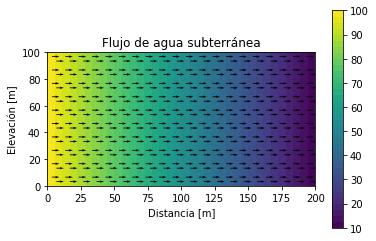

In [23]:

carga=plot(u)
flujo=plt.quiver(xx,yy,datos[:,2],datos[:,3])
plt.colorbar(carga)
plt.title('Flujo de agua subterránea')
plt.ylabel('Elevación [m]')
plt.xlabel('Distancia [m]')
plt.show()

### Modelo conceptual

Dado el caso de la vista en perfil, se realizará un corte del modelo anterior de oeste a este a
una profundidad de 100m. El cambio radica principalmente en la delimitación de las condiciones
de frontera; las fronteras laterales y la frontera inferior se supondran barreras impermeables,
mientras que la frontera superior se expresa como una función lineal donde la carga hidráulica
varia en su valor máximo (100 m) hasta su valor minimo (10 m).


<img src="../Tesis/Figura_27a.png" alt="Figura_25c.png" width="400"/>

### Modelo matemático

La ecuación diferencial que modela este problema es la misma que la del primer modelo, con la única modificación de ajustar las coordenadas X-Y a X-Z 

$$ \dfrac{\partial^{2}h}{\partial{x^{2}}}+\dfrac{\partial{^{2}h}}{\partial{z^{2}}}=0$$

Las condiciones de frontera para este problema son los siguientes:  

  $$  h=100-0.45x \quad en \quad {\partial}\Omega_{D}  $$
 
  $${\nabla}h{\cdot}\textbf{n}=0 \quad en \quad {\partial}{\Omega}_{N} $$
  


  $$ \Omega=[0,200]{\times}[0,100]\: \: Dominio \: rectangular $$
  
  $$ {\partial}\Omega_{D}={(x,100)}\: \: Condiciones \: de \: Dirichlet $$
  
  $$ {\partial}\Omega_{N}={(x,0){\cup}(0,y){\cup}(200,y)}\: \: Condiciones \: de \: Neumann $$


### Modelo computacional

Bajo la misma malla y espacio de funciones, solo se cambia la delimitación de la condición de frontera en la parte superior. La resolución y la definición de los demás paramétros se realizan de la misma forma.

In [30]:
#### Para la vista en perfil, se hace un cambio en las condiciones de frontera ####
# Se definen las condiciones de fronteras

u_S = Expression('100-0.45*x[0]', degree=1)

def frontera_S(x,frontera):
 tol=1E-14 
 if frontera:
  if abs(x[1]-100)<=tol: 
   return True
  else:
   return False 
 else:
  return False  


F_S = DirichletBC(V,u_S, frontera_S)
bc = [F_S]

In [31]:
#Se define el problema variacional

u=TrialFunction(V)
v=TestFunction(V)
f=Constant(0)
a=dot(grad(u),grad(v))*dx
g=Constant(0)
L=f*v*dx-g*v*ds

In [32]:
# Se realiza el calculo de la solucion

u= Function(V)
solve(a==L,u,bc)
tau=project(grad(u))

In [33]:
# Se organizan los valores para la exportación de los datos

xx=np.loadtxt("Coordenadascentroide.csv",delimiter=',',skiprows=1,usecols=[1])
yy=np.loadtxt("Coordenadascentroide.csv",delimiter=',',skiprows=1,usecols=[2])
datos=np.zeros((400,7))
datos[:,0]=xx
datos[:,1]=yy

for i in range(0,399):
 datos[i,2]=tau(xx[i],yy[i])[0]
 datos[i,3]=tau(xx[i],yy[i])[1]

for i in range (0,399): 
 if (datos[i,1]<50):
  datos[i,4]=10
 else:
  datos[i,4]=10

In [34]:
#Se exportan los datos de la carga hidráulica

carga=np.zeros([101,201])
for i in range (0,201):
 for j in range (0,101):
    carga[j,i]=u(i,j)

np.savetxt("carga1.2",carga)

In [35]:
# Se aplica la ecuación de Darcy para obtener el flujo q=-k*grad(u); donde k=datos[:,4] y grad(u)=(datos[:,2] y datos[:,3])
datos[:,5]=-k*datos[:,4]*datos[:,2]
datos[:,6]=-k*datos[:,4]*datos[:,3]
np.savetxt("SoluciónFlujo3.4",datos)

Además de graficar el campo de cargas hidráulicas y la descarga específica, se hace la gráfica del componente $z$ de la descarga específica, donde el valor negativo señala recarga, mientras el valor positivo señala descarga

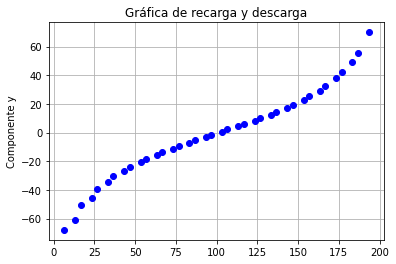

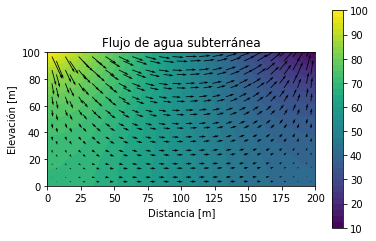

In [36]:
import matplotlib.pyplot as plt
plt.figure()
plt.plot(datos[361:399,0],datos[361:399,6],'bo')
plt.title('Gráfica de recarga y descarga')
plt.ylabel('Componente y')
plt.grid()

# Ploteo de la solucion
plt.figure()
carga=plot(u)
#plot(grad(u))
flujo=plt.quiver(xx,yy,datos[:,5],datos[:,6])
plt.colorbar(carga)
plt.title('Flujo de agua subterránea')
plt.ylabel('Elevación [m]')
#plt.colorbar(im)
#plot(mesh)
plt.title('Flujo de agua subterránea')
plt.ylabel('Elevación [m]')
plt.xlabel('Distancia [m]')
plt.show()


### Comparación con modelo analítico

El anterior problema fue planteado de forma analítica por Josef Toth en 1962 para entender la forma en que se comportaba el flujo en pequeñas cuencas de drenaje. La ecuación que
define el campo de carga hidráulica para el problema anterior, se define de la siguiente forma
(Toth,1962):




$$ h= (z_{0}+\dfrac{cs}{2})-\dfrac{4cs}{{\pi}^{2}}{\sum_{m=0}^{\infty}\dfrac{cos[(2m+1){\pi}x/s]cosh[2m+1]{\pi}z/s}{(2m+1)^{2}cosh[(2m+1){\pi}z_{0}/s]}} $$




Donde en la ecuación anterior, z0 es la condición de frontera izquierda igual a 100m; s es la
longitud de la cuenca, que en esta simulación es s = 200m; c es la pendiente de la ecuación
que define la condición de Dirichlet en la parte superior de la cuenca (45°); x y z son las coordenadas
donde se requiere encontrar la carga hidráulica h; mientras que m es una constante
en una sumatoria que mientras tienda a 1 obtendremos la solución completa. El campo de
cargas hidráulicas para las condiciones anteriormente establecidas y con m = 200 se graficó
y se comparó con la solución obtenida a partir del método de elemento finito con FEniCS.


[[69.61084825 69.60897039 69.60333747 ... 40.39666253 40.39102961
  40.38915175]
 [69.61272622 69.61084804 69.60521414 ... 40.39478586 40.38915196
  40.38727378]
 [69.61836075 69.61648161 69.61084481 ... 40.38915519 40.38351839
  40.38163925]
 ...
 [97.14221001 97.07331068 96.89078205 ... 13.10921795 12.92668932
  12.85778999]
 [98.37252243 98.24681251 97.96871542 ... 12.03128458 11.75318749
  11.62747757]
 [99.95440556 99.54813506 99.09946016 ... 10.90053984 10.45186494
  10.04559444]]


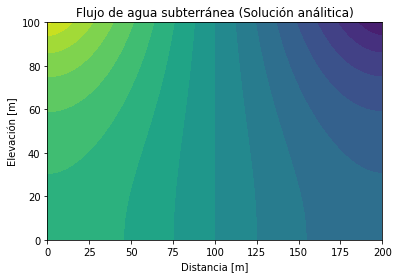

In [37]:
## Comparación con solución análitica de Toth (1969)
import math

## Parámetros
g = 1
z0 = 100
c = -0.45
s = 200

## Dominio
x=np.arange(0,201)
z=np.arange(0,101)
X,Z = np.meshgrid(x,z)
h=0
const1 = -(4*g*c*s/pi**2)
const2 = g*(z0+(c*s/2))

# Sumatoria infinita (Se corta hasta 200), para obtener el resultado del flujo
for m in range(200):
    h1 = np.cos((2*m+1)*np.pi*(X/s))*np.cosh((2*m+1)*np.pi*Z/s)
    h2 = ((2*m+1)**2)*np.cosh((2*m+1)*np.pi*z0/s)
    sumah=h1/h2
    h=h+sumah

hfinal = const2 + (const1*h)
plt.title('Flujo de agua subterránea (Solución análitica)')
plt.ylabel('Elevación [m]')
plt.xlabel('Distancia [m]')
prueba = plt.contourf(X,Z,h, 20, cmap = "viridis")
# plt.colorbar(prueba)
print(hfinal)

In [38]:
errgraph = np.zeros((101,201))
for j in range(201):
 for i in range(101):
    errgraph[i,j] = hfinal[i,j]-u(j,i)
    

Se obtiene y gráfica el valor absoluto de la diferencia entre el valor análitico y la solución en Fenics. Las zonas amarillas indican mayor incertidumbre. 

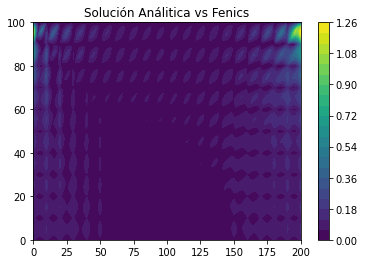

In [39]:
plt.title('Solución Análitica vs Fenics')
prueba = plt.contourf(X,Z,abs(errgraph), 20, cmap = "viridis")
plt.colorbar(prueba)
# print(hfinal)